<a href="https://colab.research.google.com/github/reitezuz/notebooks-for-NES2-2024/blob/main/lecture_05/multiclass_classification_mnist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Multiclass classification example - classifying digits from the MNIST dataset

Inspired by: https://github.com/fchollet/deep-learning-with-python-notebooks/blob/master/chapter02_mathematical-building-blocks.ipynb  

MNIST dataset is a dataset of handwritten digits. It contains a training set of 60000 greyscale 28x28 images and a testing set of 10000 images of digits written by different people.

https://yann.lecun.com/exdb/mnist/
https://en.wikipedia.org/wiki/MNIST_database

## Load, view and analyze the data

In [1]:
# Load the MNIST dataset

from keras.datasets import mnist
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()



Observe the data:

In [2]:
import numpy as np

# 60000 training samples - images 28x28 in greyscale
print(train_images.shape, train_labels.shape)

# 10000 testing samples - images 28x28 in greyscale
print(test_images.shape, test_labels.shape)

# 10 categories
print(len(train_labels), train_labels[:10], np.min(train_labels), np.max(train_labels))

print("Extremes of pixel values:", np.min(train_images), np.max(train_images))

# Distribution of training and testing labels
print("Label distribution:", np.bincount(train_labels))
print("Label distribution:", np.bincount(test_labels))

# Check for missing values
print("Number of missing values in training images:", np.sum(np.isnan(train_images)))
print("Number of missing values in test images:", np.sum(np.isnan(test_images)))

(60000, 28, 28) (60000,)
(10000, 28, 28) (10000,)
60000 [5 0 4 1 9 2 1 3 1 4] 0 9
Extremes of pixel values: 0 255
Label distribution: [5923 6742 5958 6131 5842 5421 5918 6265 5851 5949]
Label distribution: [ 980 1135 1032 1010  982  892  958 1028  974 1009]
Number of missing values in training images: 0
Number of missing values in test images: 0


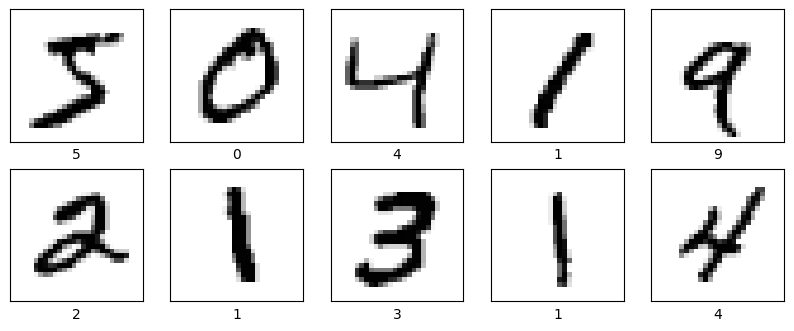

In [3]:
# Display some images

import matplotlib.pyplot as plt

# Display the first 10 images
plt.figure(figsize=(10, 10))
for i in range(10):
    plt.subplot(5, 5, i + 1)
    plt.xticks([])  # Remove axis ticks and the grids
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i], cmap=plt.cm.binary) # Display the current image using a binary color map
    plt.xlabel(train_labels[i])
plt.show()


**Observation:** 
1. The letters are well centered and similar in size, no values ​​are missing, there are no missing values -> we need no data augmentation
2. The input data have the form of 3D-tensor. 
3. The pixels have values 0...255.

## Preprocess the data


In [4]:
import keras
# 1. Reshape and normalize the data:
# reshape the data into a flat vector (784 elements) for input to our neural network.
x_train_0 = train_images.reshape(60000, 28 * 28)
x_test_0 = test_images.reshape(10000, 28 * 28)
y_train = train_labels
y_test = test_labels

# 2. Convert the pixel values from integers [0-255] to floating-point numbers and normalize them to the range [0, 1].
x_train = x_train_0.astype('float32') / 255
x_test = x_test_0.astype('float32') / 255

# 3. Arbitrary: one-hot encode the labels:
# For example, the label 3 would become [0, 0, 0, 1, 0, 0, 0, 0, 0, 0].
y_train_categorical = keras.utils.to_categorical(y_train, num_classes=10)
y_test_categorical  = keras.utils.to_categorical(y_test, num_classes=10)

# print(x_train[1])
print(y_train[:3])
print(y_train_categorical[:3])

# 4. Split the training data into training and validation sets
# The validation set is used to monitor the performance of the model during training and prevent overfitting.
from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.1)



[5 0 4]
[[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]]


In [5]:
# Alternative data normalization: standard scaling to center the data around zero and achieve a unit standard deviation

from sklearn.preprocessing import StandardScaler

# Create a StandardScaler object
scaler = StandardScaler()

# Fit the scaler on the training data and transform it
x_train_s = scaler.fit_transform(x_train_0)

# Transform the test and validation data using the same scaler
x_test_s = scaler.transform(x_test_0)

# Mean and standard deviation for the two variants of normalization:
print(np.mean(x_train_s), np.std(x_train_s), np.mean(x_test_s), np.std(x_test_s))
print(np.mean(x_train), np.std(x_train), np.mean(x_test), np.std(x_test))

-2.1974863349995617e-18 0.9563162742140049 0.002495697308915079 0.9571450819920649
0.13065773 0.30810332 0.13251467 0.31048027


## Define and train the model

### MLP model for multiclass classification:
- 'softmax' activation function in the output layer 
- 'relu' or 'tanh' in the hidden layers
- if labels are one-hot vectors:
    CategoricalCrossentropy  loss function and CategoricalAccuracy metrics

- if labels are provided as integers:
     SparseCategoricalCrossentropy  loss function and SparseCategoricalAccuracy metrics


In [6]:
# Data frame for results
import pandas as pd

columns = ["Model Name", "Details", "Test Accuracy", "Test Loss"]
results_df = pd.DataFrame(columns=columns)

In [8]:
###############################################
# Define the log directory for TensorBoard
import os
import datetime
import keras
import tensorflow as tf

model_datetime_name = "mnist_mlp_"+  datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
log_dir = "./logs/fit_mnist/" + model_datetime_name
# print(os.getcwd())

# Clear any logs from previous runs
# !rm -rf ./logs/

# Ensure the directory exists
if not os.path.exists(os.path.dirname(log_dir)):
    os.makedirs(os.path.dirname(log_dir))

###############################################
# Initialize Tensorboard callback
tensorboard_callback = keras.callbacks.TensorBoard(
    log_dir=log_dir,
    histogram_freq=1,  # Visualize histograms of layer weights
    write_graph=True,  # Log the graph to visualize the model structure
    write_images=True  # Optionally, save images of weights and activation histograms
    # update_freq='batch'  # Log metrics after every batch
    # write_steps_per_second=True  # Log steps per second during training
)
################################################


# define the model architecture
model = keras.Sequential([
    keras.layers.InputLayer(shape=(28 * 28,)),
    keras.layers.Dense(512, activation='relu'),
    keras.layers.Dense(10, activation='softmax')
])

model.summary()

# Set model parameters
model.compile(optimizer= keras.optimizers.SGD(learning_rate = 0.001), # Adam, RMSProp         
              loss= keras.losses.SparseCategoricalCrossentropy(),                
              metrics= [keras.metrics.SparseCategoricalAccuracy("accuracy")]) 

num_epochs = 10
batch_size = 128

# Train the model
history = model.fit(x_train,
                    y_train,
                    epochs=num_epochs,
                    batch_size=batch_size,
                    validation_data=(x_val, y_val),
                    callbacks=[tensorboard_callback])

# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(x_test, y_test)
print('Test accuracy:', test_acc, '\nTest loss:', test_loss)

# Save the model
model_dir = "./models/"

# Ensure the directory exists
if not os.path.exists(os.path.dirname(model_dir)):
    os.makedirs(os.path.dirname(model_dir))
# Create a unique model name using the current date and time
model_name = model_dir + model_datetime_name + ".keras"
# Save the model with the generated name
model.save(model_name)

model_details = "512"
# Add results to the dataframe: 
new_entry = {
    "Model Name" : model_datetime_name,
    "Details" : model_details,
    "Test Accuracy" : test_acc, 
    "Test Loss" : test_loss, 
}
results_df = pd.concat([results_df, pd.DataFrame([new_entry])], ignore_index=True)

# View and and save the dataframe:
print("Results:")
print(results_df)
results_df.to_csv(model_dir + "mnist_results.csv", index=False)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_2 (Dense)                 │ (None, 512)            │       401,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │         5,130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 407,050 (1.55 MB)

 Trainable params: 407,050 (1.55 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 9s 20ms/step - accuracy: 0.1974 - loss: 2.2402 - val_accuracy: 0.5703 - val_loss: 1.8988
Epoch 2/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 9s 16ms/step - accuracy: 0.6296 - loss: 1.8048 - val_accuracy: 0.7203 - val_loss: 1.5632
Epoch 3/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 11s 18ms/step - accuracy: 0.7370 - loss: 1.4916 - val_accuracy: 0.7705 - val_loss: 1.3076
Epoch 4/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 9s 14ms/step - accuracy: 0.7822 - loss: 1.2560 - val_accuracy: 0.7962 - val_loss: 1.1192
Epoch 5/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accuracy: 0.8041 - loss: 1.0780 - val_accuracy: 0.8178 - val_loss: 0.9820
Epoch 6/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 13s 19ms/step - accuracy: 0.8202 - loss: 0.9483 - val_accuracy: 0.8293 - val_loss: 0.8805
Epoch 7/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 11s 18ms/step - accuracy: 0.8318 - loss: 0.8540 - val_accuracy: 0.8377 - val_loss: 0.8039
Epoch 8/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.8380 - loss: 0.7844 - val_ac

C:\Users\zuzka\AppData\Local\Temp\ipykernel_21624\102072699.py:80: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results_df = pd.concat([results_df, pd.DataFrame([new_entry])], ignore_index=True)


dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])


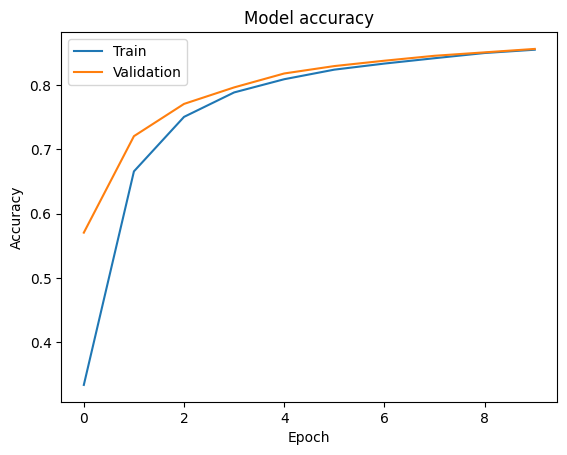

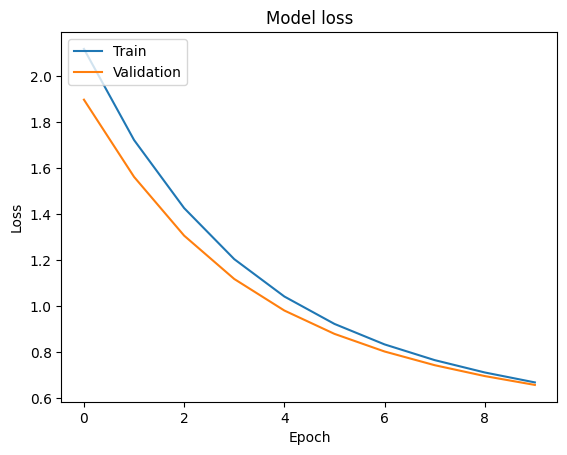

1688/1688 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - accuracy: 0.8549 - loss: 0.6555
Training accuracy: 0.8571666479110718 
Train loss: 0.650435209274292
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8482 - loss: 0.6661
Validation accuracy: 0.8560000061988831 
Val loss: 0.6585355401039124
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8463 - loss: 0.6935
Test accuracy: 0.8682000041007996 
Test loss: 0.625602662563324


In [9]:
# plot the training progress:
import matplotlib.pyplot as plt

history_dict = history.history
print(history_dict.keys())

# Plot training & validation accuracy values
plt.plot(history_dict['accuracy'])
plt.plot(history_dict['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history_dict['loss'])
plt.plot(history_dict['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


# Evaluate the model on the training set
train_loss, train_acc = model.evaluate(x_train, y_train)
print('Training accuracy:', train_acc, '\nTrain loss:', train_loss)

# Evaluate the model on the validation set
val_loss, val_acc = model.evaluate(x_val, y_val)
print('Validation accuracy:', val_acc, '\nVal loss:', val_loss)

# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(x_test, y_test)
print('Test accuracy:', test_acc, '\nTest loss:', test_loss)

## Evaluate the model and make predictions on new data

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step
[0.00628372 0.0017007  0.00569907 0.0079638  0.01332044 0.00744151
 0.00318137 0.884554   0.01209155 0.05776384]
Predicted labels: [7 2 1 0 4 1 4 9 6 9]
True labels: [7 2 1 0 4 1 4 9 5 9]
Number of misclassified images: 1318 out of 10000 , accuracy 0.8682000041007996


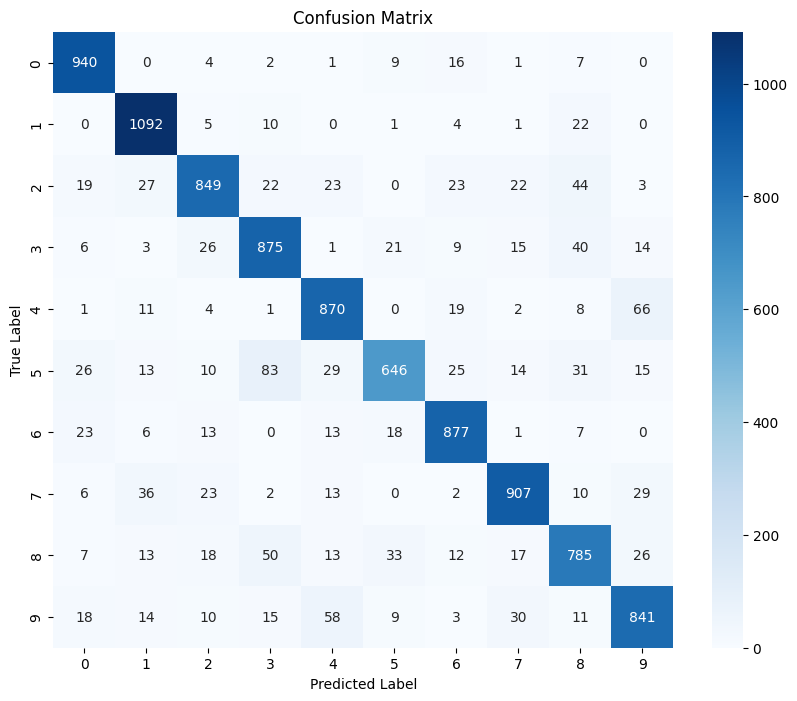

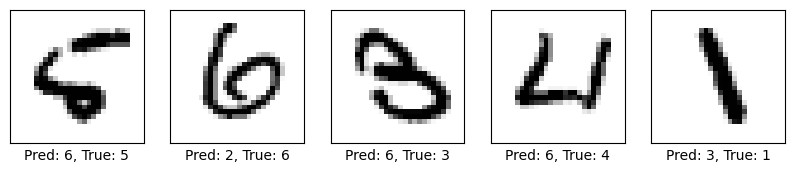

In [10]:
# Get predicted probabilities for the test set
y_pred_probs = model.predict(x_test)
print(y_pred_probs[0])

# Get the predicted class for each sample
y_pred = np.argmax(y_pred_probs, axis=1)

print("Predicted labels:", y_pred[:10])
print("True labels:", y_test[:10])

# Misclassified indices:
misclassified_indices = np.where(y_pred != y_test)[0]
num_misclassified = len(misclassified_indices)
print("Number of misclassified images:", num_misclassified, 
      "out of", len(y_test), ", accuracy", test_acc)

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Plot some misclassified images
num_images_to_plot = 5
plt.figure(figsize=(10, 10))
for i in range(min(num_images_to_plot, len(misclassified_indices))):
    index = misclassified_indices[i]
    plt.subplot(1, num_images_to_plot, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(test_images[index], cmap=plt.cm.binary)
    plt.xlabel(f"Pred: {y_pred[index]}, True: {y_test[index]}")
plt.show()

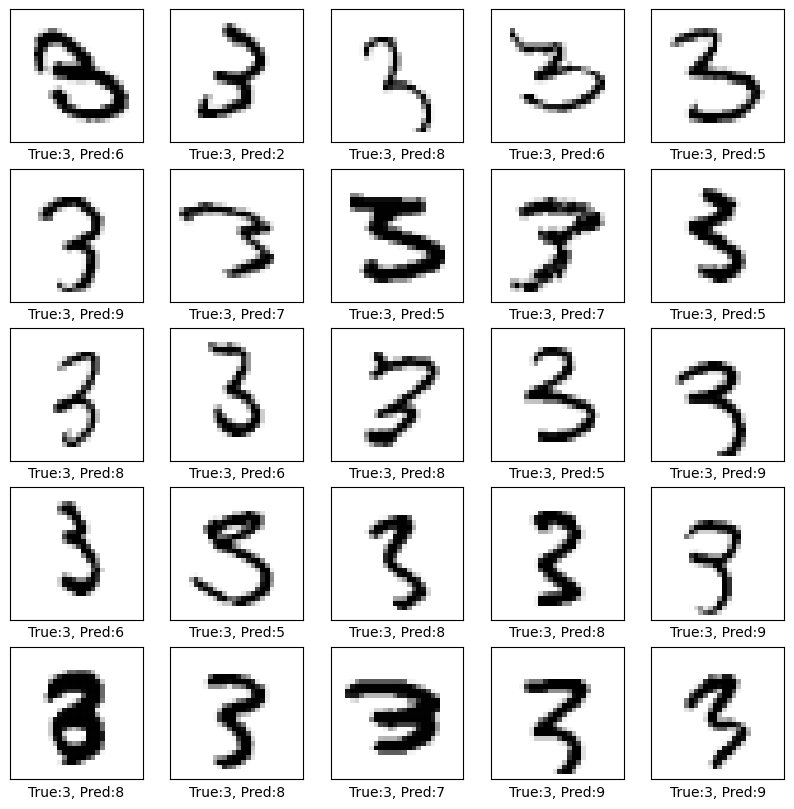

In [11]:
# Plot some misclassified images from a given target (or predicted) class
target_class = 3
misclassified_indices_class = np.where((y_pred != y_test) & (y_test == target_class))[0]
#misclassified_indices_class = np.where((y_pred != y_test) & (y_pred == target_class))[0]



# Display the first 25 misclassified images for the target class
plt.figure(figsize=(10, 10))
for i in range(min(25, len(misclassified_indices_class))):
    index = misclassified_indices_class[i]
    plt.subplot(5, 5, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(test_images[index], cmap=plt.cm.binary)
    plt.xlabel(f"True:{y_test[index]}, Pred:{y_pred[index]}")
plt.show()


# Exercises
1. **Change the number of layers and neurons in the model**. Observe how this affects the model's accuracy. You can also experiment with different **activation functions** in the hidden layers.
2. **Experiment with the number of epochs and learning rate**. Plot the learning curves to visualize the differences in training.
3. **Change the loss function**. Try using `categorical_crossentropy` with one-hot encoded labels (`y`).
4. **Experiment with different batch sizes**. Observe how different batch sizes affect the model's accuracy and training time.
5. **Try an alternative normalization method for the input data** (e.g., standardization). Observe how this affects the model's performance.
6. **Analyze the confusion matrix**. Use the confusion matrix to identify pairs of classes that are most frequently misclassified.
7. **Try changing the optimizer used in the model**. Experiment with optimizers such as Adam, RMSprop, or Adagrad to see how they impact model accuracy and training time.


### What else to mention study?
- callbacks to monitor and control the training process
- finetuning of the model
- hyperparameter tuning
- visualize the model's internal representations
- methods that improve the model's performance (batch normalization,...)
- learning rate scheduling
- Regularization techniques (L1, L2, dropout) to prevent overfitting
- data augmentation
- crossvalidation

## Callbacks to monitor and control the training process

In [12]:
# example: add validation set to the training log

...

num_epochs = 2

# Add test data to the log
def evaluate_val(epoch, logs):
    test_logs = model.evaluate(
              x_test, y_test, batch_size, return_dict=True, verbose=0,
          )

    logs.update({" val_" + name: value for name, value in test_logs.items()})

evaluate_val_callback = keras.callbacks.LambdaCallback(on_epoch_end=evaluate_val)

# Train the model with callbacks
model.fit(x_train, y_train, epochs=num_epochs, batch_size = batch_size, callbacks=[evaluate_val_callback, tensorboard_callback])

...

Epoch 1/2
422/422 ━━━━━━━━━━━━━━━━━━━━ 9s 21ms/step - accuracy: 0.8587 - loss: 0.6418 -  val_accuracy: 0.8731 -  val_loss: 0.5935
Epoch 2/2
422/422 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - accuracy: 0.8621 - loss: 0.6103 -  val_accuracy: 0.8764 -  val_loss: 0.5668


Ellipsis

In [13]:
###############################################
# Load TensorBoard notebook extension
%load_ext tensorboard

# Start TensorBoard before training begins
%tensorboard --logdir logs/fit_mnist --reload_interval=1

Reusing TensorBoard on port 6006 (pid 11076), started 13 days, 4:38:12 ago. (Use '!kill 11076' to kill it.)